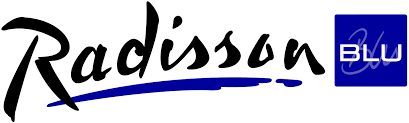

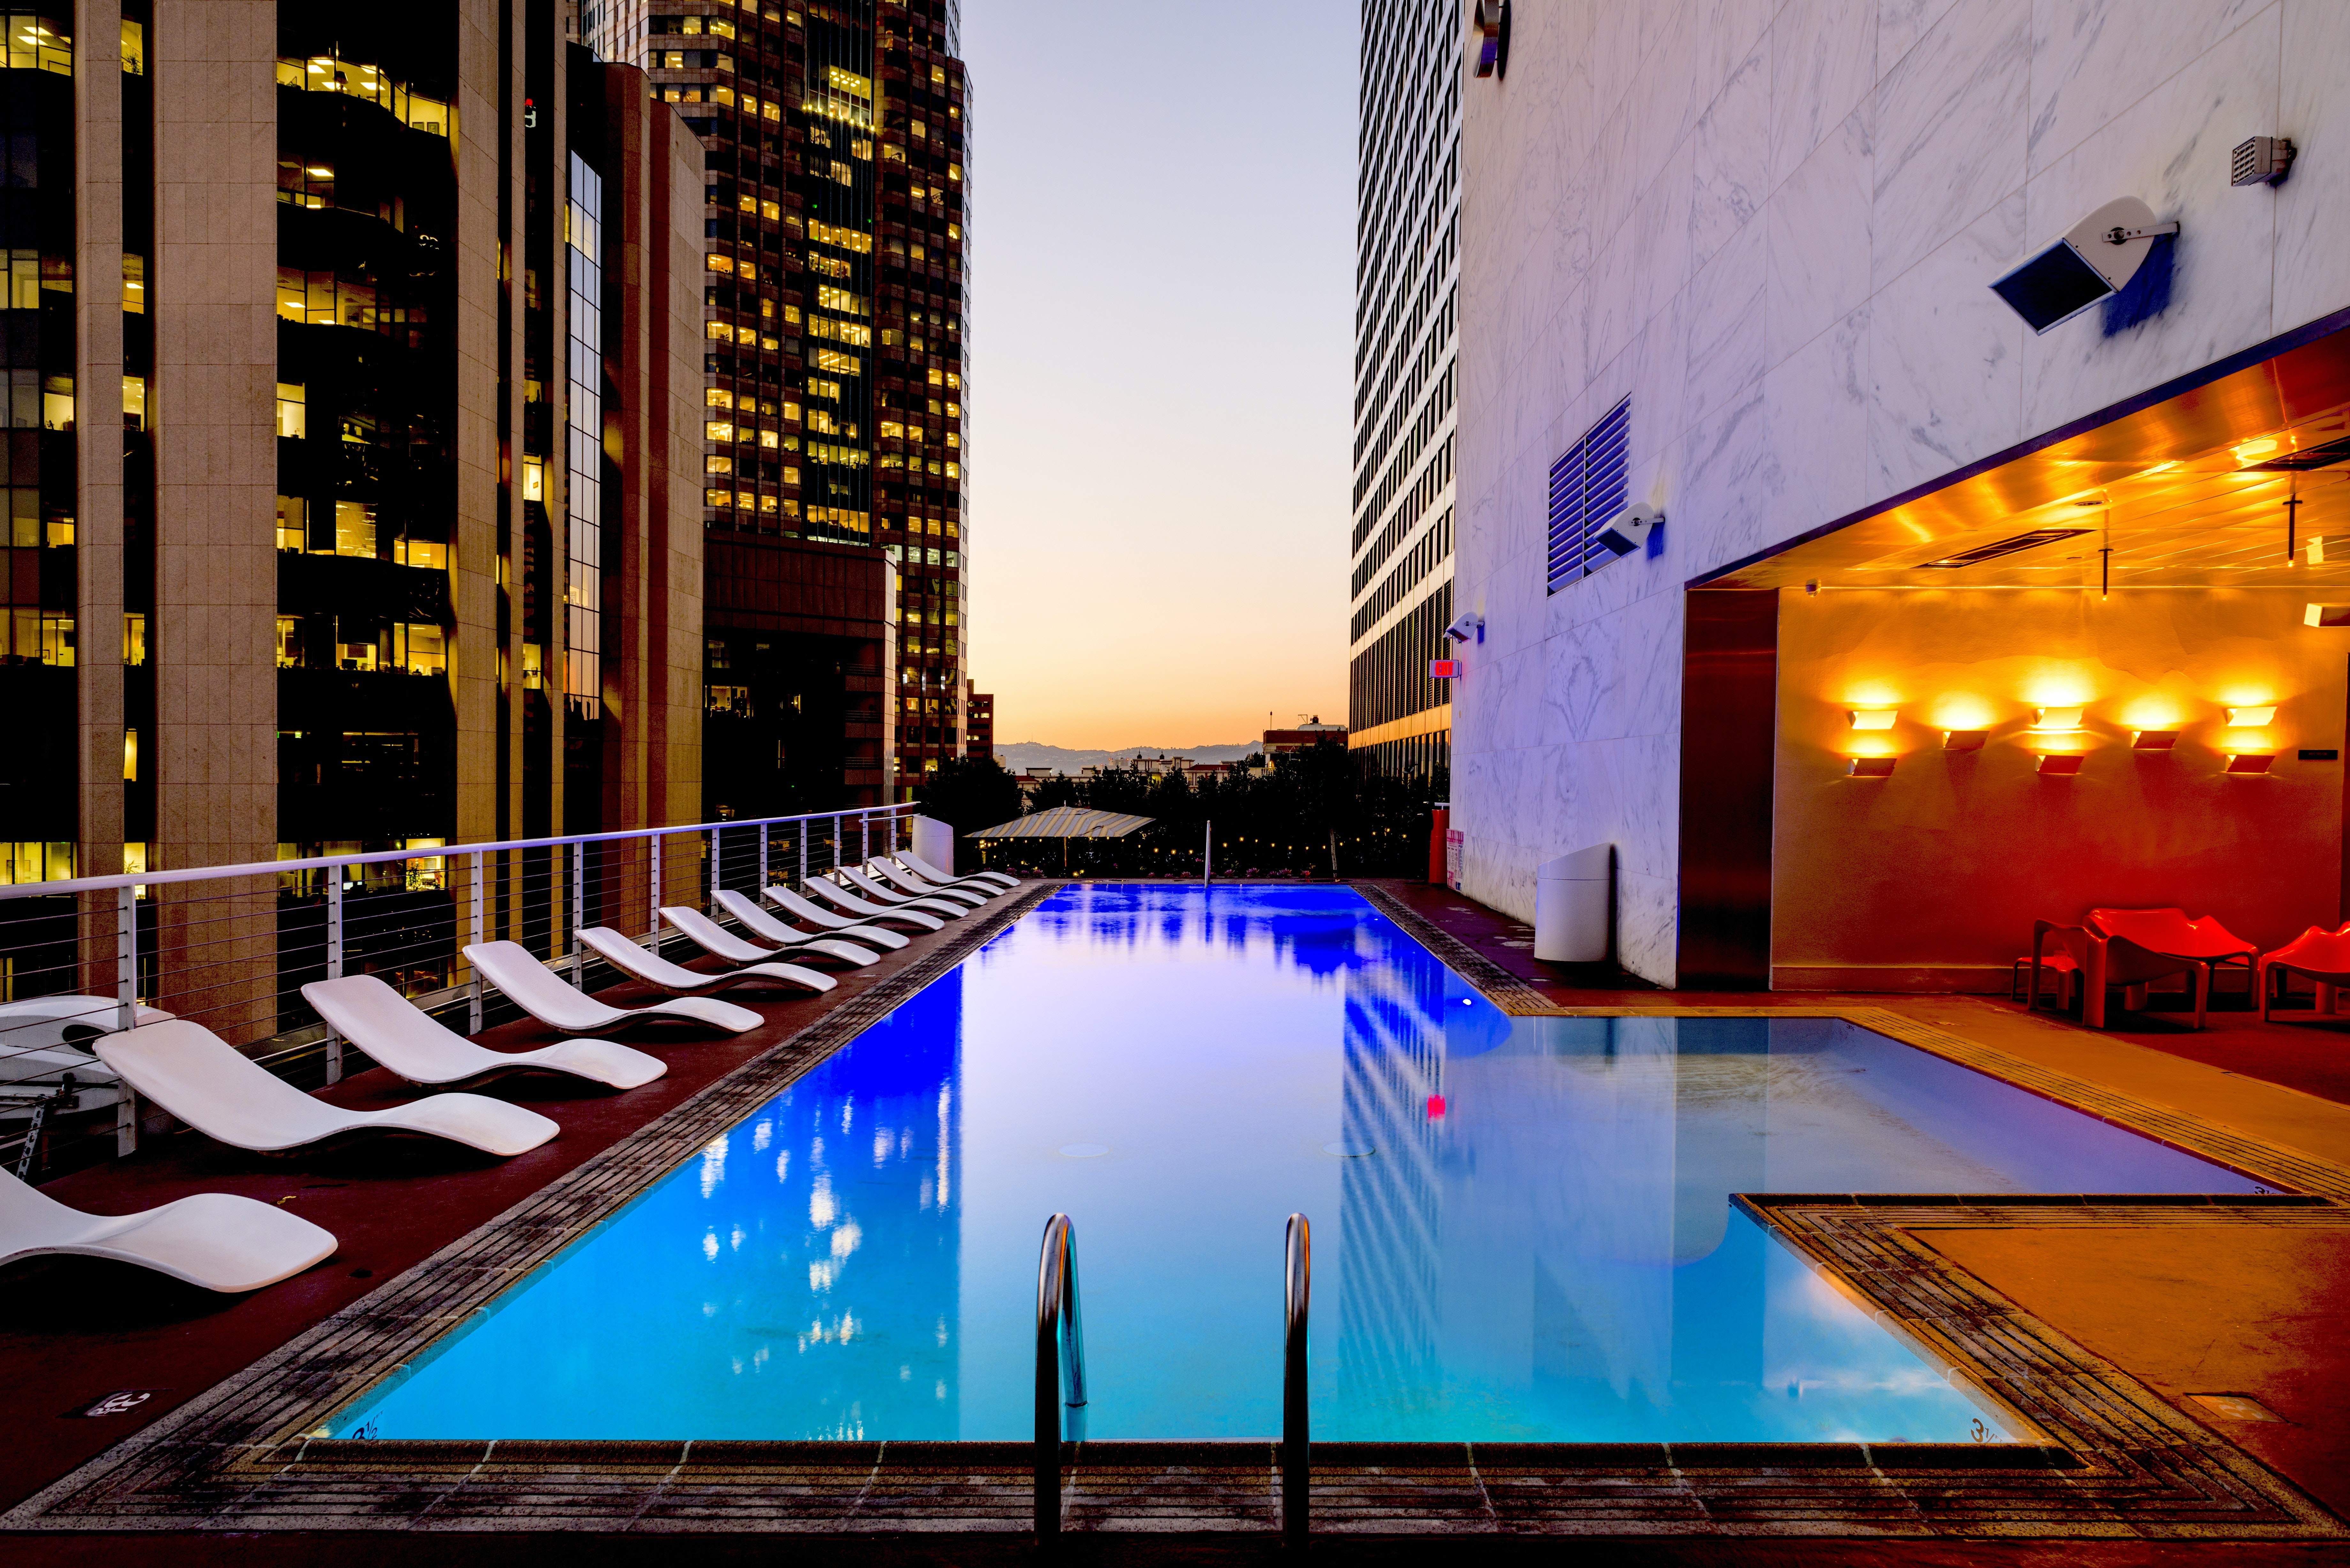

#### Predictive Modelling on the hotel reservations dataset¶
https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In this project,we will first check for the correlation between the variables before feature selection. Also, we will work with four different models to test which performed better and then use that model for prediction.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hotel-reservations-classification-dataset/Hotel Reservations.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from pandas import DataFrame
import numpy as np


In [3]:
df = pd.read_csv("/kaggle/input/hotel-reservations-classification-dataset/Hotel Reservations.csv")
df.head(3)

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_Type 1          5          2018             11             6   
2        Room_Type 1          1          2018              2            28   

  market_segment_type  repeated_guest  no_of_previous_cancellations  \
0             Offline               0                             0   
1              Online               0                             0   
2              Online               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled

With our categorical label, there is a need for a Label Encoder.

In [4]:
df = df.rename(columns={'booking_status': 'is_canceled'})
df['is_canceled'].replace('Canceled', '1',inplace=True)
df['is_canceled'].replace('Not_Canceled', '0',inplace=True)
df.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_Type 1          5          2018             11             6   
2        Room_Type 1          1          2018              2            28   
3        Room_Type 1        211          2018              5            20   
4        Room_Type 1         48          2018              4            11   

  market_segment_type  repeated_guest  no_of_previous_cancellations  \
0             Offline               0                             0   
1              Online               0                             0   
2              Online               0                             0   
3              Online               0                             0   
4              Online               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests is_canceled  
0                       0           0  
1                       1           0  
2                       0           1  
3                       0           1  
4                       0           1

In [5]:
df['is_canceled'] = df['is_canceled'].astype(int)


In [6]:
train_set,test_set=train_test_split(df,random_state=42,test_size=0.2)

In [7]:
hotel_df=train_set.copy()


### Correlation plot

In [8]:
hotel_df_corr=hotel_df.corr()

corr_df= DataFrame(hotel_df_corr['is_canceled'].abs().sort_values(ascending=False))
     

<AxesSubplot: >

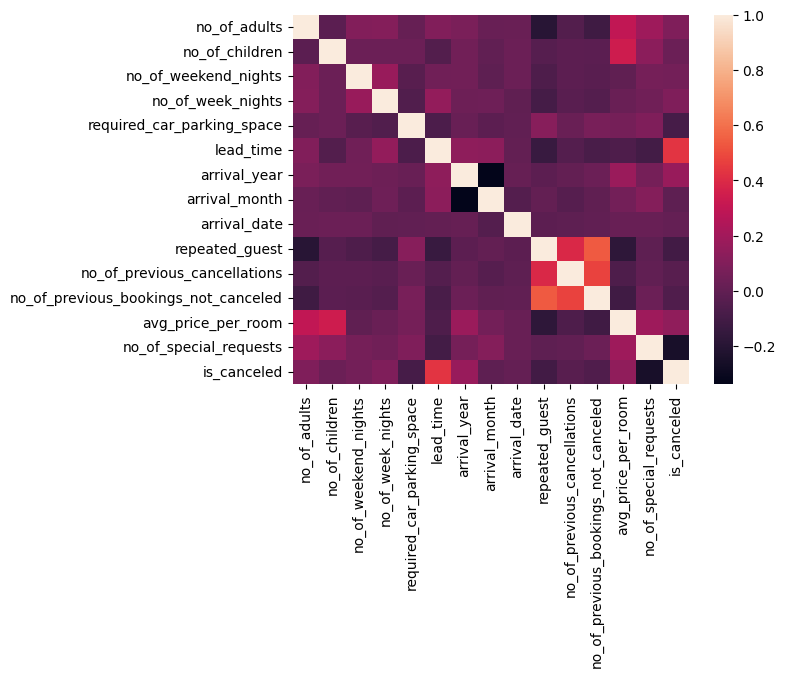

In [9]:
sns.heatmap(hotel_df_corr)


In [10]:
corr_df=corr_df.reset_index().rename(columns={'index':'corr_val'})


In [11]:
cols=corr_df['corr_val'].unique()
hotel_df[cols].head().columns

Index(['is_canceled', 'lead_time', 'no_of_special_requests', 'arrival_year',
       'avg_price_per_room', 'repeated_guest', 'no_of_week_nights',
       'no_of_adults', 'required_car_parking_space',
       'no_of_previous_bookings_not_canceled', 'no_of_weekend_nights',
       'no_of_previous_cancellations', 'no_of_children', 'arrival_month',
       'arrival_date'],
      dtype='object')

In [12]:
hotel_df[cols].head(2)


is_canceled  lead_time  no_of_special_requests  arrival_year  \
25629            0         26                       0          2017   
14473            0         98                       2          2018   

       avg_price_per_room  repeated_guest  no_of_week_nights  no_of_adults  \
25629               161.0               0                  1             2   
14473               121.5               0                  1             2   

       required_car_parking_space  no_of_previous_bookings_not_canceled  \
25629                           0                                     0   
14473                           0                                     0   

       no_of_weekend_nights  no_of_previous_cancellations  no_of_children  \
25629                     2                             0               1   
14473                     1                             0               1   

       arrival_month  arrival_date  
25629             10            17  
14473              7            16

In [13]:
hotel_df.select_dtypes(include="number").columns


Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space', 'lead_time',
       'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'is_canceled'],
      dtype='object')

In [14]:
hotel_df.select_dtypes(include="object").columns


Index(['Booking_ID', 'type_of_meal_plan', 'room_type_reserved',
       'market_segment_type'],
      dtype='object')

## Feature Selection:
 We will need to choose numerical and categorical columns for our model

In [15]:
numeric_cols=['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space', 'lead_time',
       'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests']

cat_cols=[ 'type_of_meal_plan', 'room_type_reserved',
       'market_segment_type']

In [16]:
hotel_df_actual=hotel_df[numeric_cols + cat_cols]
hotel_df_y=hotel_df['is_canceled']
     

In [17]:
hotel_df_actual.describe().T


count         mean        std     min  \
no_of_adults                          29020.0     1.844280   0.518692     0.0   
no_of_children                        29020.0     0.106306   0.405391     0.0   
no_of_weekend_nights                  29020.0     0.807822   0.868111     0.0   
no_of_week_nights                     29020.0     2.202068   1.402801     0.0   
required_car_parking_space            29020.0     0.031943   0.175853     0.0   
lead_time                             29020.0    85.376085  85.859070     0.0   
arrival_year                          29020.0  2017.820434   0.383832  2017.0   
arrival_month                         29020.0     7.416506   3.060058     1.0   
arrival_date                          29020.0    15.598725   8.740151     1.0   
repeated_guest                        29020.0     0.025775   0.158467     0.0   
no_of_previous_cancellations          29020.0     0.023880   0.375994     0.0   
no_of_previous_bookings_not_canceled  29020.0     0.154721   1.777787     0.0   
avg_price_per_room                    29020.0   103.501785  35.137794     0.0   
no_of_special_requests                29020.0     0.619917   0.786348     0.0   

                                         25%      50%      75%     max  
no_of_adults                             2.0     2.00     2.00     4.0  
no_of_children                           0.0     0.00     0.00    10.0  
no_of_weekend_nights                     0.0     1.00     2.00     6.0  
no_of_week_nights                        1.0     2.00     3.00    17.0  
required_car_parking_space               0.0     0.00     0.00     1.0  
lead_time                               17.0    58.00   127.00   443.0  
arrival_year                          2018.0  2018.00  2018.00  2018.0  
arrival_month                            5.0     8.00    10.00    12.0  
arrival_date                             8.0    16.00    23.00    31.0  
repeated_guest                           0.0     0.00     0.00     1.0  
no_of_previous_cancellations             0.0     0.00     0.00    13.0  
no_of_previous_bookings_not_canceled     0.0     0.00     0.00    58.0  
avg_price_per_room                      80.5    99.85   120.12   375.5  
no_of_special_requests                   0.0     0.00     1.00     5.0

### Numeric pipeline



In [18]:
hotel_df_actual.head()


no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
25629             2               1                     2                  1   
14473             2               1                     1                  1   
23720             2               0                     0                  3   
5843              2               0                     2                  5   
18709             1               0                     0                  2   

       required_car_parking_space  lead_time  arrival_year  arrival_month  \
25629                           0         26          2017             10   
14473                           0         98          2018              7   
23720                           0        433          2018              9   
5843                            0        195          2018              8   
18709                           0        188          2018              6   

       arrival_date  repeated_guest  no_of_previous_cancellations  \
25629            17               0                             0   
14473            16               0                             0   
23720             8               0                             0   
5843              8               0                             0   
18709            15               0                             0   

       no_of_previous_bookings_not_canceled  avg_price_per_room  \
25629                                     0              161.00   
14473                                     0              121.50   
23720                                     0               70.00   
5843                                      0               72.25   
18709                                     0              130.00   

       no_of_special_requests type_of_meal_plan room_type_reserved  \
25629                       0       Meal Plan 1        Room_Type 1   
14473                       2       Meal Plan 1        Room_Type 1   
23720                       0       Meal Plan 1        Room_Type 1   
5843                        0       Meal Plan 1        Room_Type 1   
18709                       0       Meal Plan 1        Room_Type 1   

      market_segment_type  
25629              Online  
14473              Online  
23720             Offline  
5843              Offline  
18709             Offline

  Changing the values in categorical to numerical values and filling in missing values in both numeric and categorical variables.

In [19]:
num_transformer=SimpleImputer(strategy="constant",fill_value=0)

#num_transformer.fit_transform(hotel_df[numeric_cols])
cat_transformer=Pipeline([('imputer',SimpleImputer(strategy="constant")),('ordinal',OrdinalEncoder())])

#combine the two so we can use it for other data sets

col_trans=ColumnTransformer([("num",num_transformer,numeric_cols),("cat",cat_transformer,cat_cols)])

In [20]:
col_trans


ColumnTransformer(transformers=[('num',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['no_of_adults', 'no_of_children',
                                  'no_of_weekend_nights', 'no_of_week_nights',
                                  'required_car_parking_space', 'lead_time',
                                  'arrival_year', 'arrival_month',
                                  'arrival_date', 'repeated_guest',
                                  'no_of_previous_cancellations',
                                  'no_of_previous_bookings_not_canceled',
                                  'avg_price_per_room',
                                  'no_of_special_requests']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['type_of_meal_plan', 'room_type_reserved',
                                  'market_segment_type'])])

In [22]:
X_train,X_test,y_train,y_test=train_test_split(hotel_df_actual,hotel_df_y,test_size=0.2,random_state=42,stratify=hotel_df_y)


In [23]:
model=LogisticRegression(random_state=42,n_jobs=-1)

model_steps=Pipeline([('col_trans',col_trans),('model',model)])

model_steps.fit(X_train,y_train)

y_pred=model_steps.predict(X_test)

model_steps.score(X_test,y_test)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7953135768435562

In [24]:
cv_results=cross_val_score(model_steps,X_train,y_train,cv=5,n_jobs=-1,scoring='accuracy')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as sh

In [25]:
cv_results


array([0.77971576, 0.80142149, 0.78785268, 0.7964678 , 0.78677579])

In [26]:
cv_results=[x for x in cv_results if str(x) !="nan"]
np.mean(cv_results)

0.7904467061915885

So now we want have our base model, now let's choose the models we want to use then work on those



In [27]:
clf1=LogisticRegression(penalty='l2',C=0.001,random_state=42)
clf2=DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=42)
clf3=RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=42)
clf4=xgb.XGBClassifier(n_estimators=100,learning_rate=0.01,max_depth=4,random_state=1,use_label_encoder=False)

models_name=['Logisstic Reg','Decision Tree','RandomForest','XGB']

for clf,name in zip([clf1,clf2,clf3,clf4],models_name):
  model_steps=Pipeline([('col_trans',col_trans),('model',clf)])
  scores=cross_val_score(model_steps,X_train,y_train,cv=4,n_jobs=-1,scoring="accuracy")
  scores=[x for x in scores if str(x) !="nan"]
  print('accuracy:{:.2f},{}'.format(np.mean(scores),name))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

accuracy:0.78,Logisstic Reg
accuracy:0.82,Decision Tree
accuracy:0.90,RandomForest
accuracy:0.84,XGB


Our Best Model is Random Forest, so let's take that and do some hyperparameter tunning on it



In [30]:

RF=RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=42)

model=Pipeline([('col_trans',col_trans),('model',RF)])

model.fit(X_train,y_train)

model.get_params()

{'memory': None,
 'steps': [('col_trans',
   ColumnTransformer(transformers=[('num',
                                    SimpleImputer(fill_value=0,
                                                  strategy='constant'),
                                    ['no_of_adults', 'no_of_children',
                                     'no_of_weekend_nights', 'no_of_week_nights',
                                     'required_car_parking_space', 'lead_time',
                                     'arrival_year', 'arrival_month',
                                     'arrival_date', 'repeated_guest',
                                     'no_of_previous_cancellations',
                                     'no_of_previous_bookings_not_canceled',
                                     'avg_price_per_room',
                                     'no_of_special_requests']),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                            

In [31]:
clf3=RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=42)
model=Pipeline([('col_trans',col_trans),('model',clf3)])

param_range=[100,160]
#param_criterion=['gini','entropy']
param_grids=[{'model__n_estimators':param_range,'model__criterion':['entropy']}]
             #{'model__n_estimators':param_range,'model__criterion':['entropy'],'model__min_samples_split':param_min_samples_split}]

gs=GridSearchCV(estimator=model,param_grid=param_grids,scoring='accuracy',cv=10,refit=True,n_jobs=-1)

gs=gs.fit(X_train,y_train)

In [32]:
print(gs.best_estimator_)

print(gs.best_score_)

print(gs.best_params_)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'required_car_parking_space',
                                                   'lead_time', 'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'repeated_guest',
                                                   'no_of_previous_cancellations',
                  

In [33]:
clf3=RandomForestClassifier(n_estimators=160,max_features=0.4,min_samples_split=2,n_jobs=-1,random_state=42)
model_clf=Pipeline([('col_trans',col_trans),('model',clf3)])

cv_result_score=cross_val_score(model_clf,X_train,y_train,cv=5,scoring='accuracy',n_jobs=-1)
cv_result_score=[x for x in cv_result_score if str(x) !="nan"]

np.mean(cv_result_score)

0.8964936055369768

In [34]:
model_clf.fit(X_train,y_train)

#.get_feature_names(input_features=cat_cols)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'required_car_parking_space',
                                                   'lead_time', 'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'repeated_guest',
                                                   'no_of_previous_cancellations',
                                                   'no_of_previous_bookings_not_canceled',
                                                   'avg_price_per_room',
                                                   'no_of_special_requests']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['type_of_meal_plan',
                                                   'room_type_reserved',
                                                   'market_segment_type'])])),
                ('model',
                 RandomForestClassifier(max_features=0.4, n_estimators=160,
                                        n_jobs=-1, random_state=42))])

In [35]:
model_clf.steps[1][1].feature_importances_


array([2.48738341e-02, 6.45257110e-03, 3.62002395e-02, 4.95059706e-02,
       6.28146264e-03, 3.34668313e-01, 2.45816110e-02, 7.38903365e-02,
       8.56897300e-02, 1.36400822e-03, 2.75210771e-04, 8.03245916e-04,
       1.67936428e-01, 9.34464004e-02, 1.63907900e-02, 1.45144083e-02,
       6.31254402e-02])

In [36]:
num=model_clf.named_steps['col_trans'].transformers_[0][2]
#['col_trans'].transformers_[1][1].named_steps['ordinal'].get_feature_names(cat_cols)

In [37]:
cat=model_clf.named_steps['col_trans'].transformers_[1][2]


In [38]:
features=num+cat


In [39]:
feat=DataFrame(features)
weight=DataFrame(model_clf.steps[1][1].feature_importances_)

imp_df=pd.concat([feat,weight],axis=1,keys=['Feature','Weight'])

In [40]:
imp_df=imp_df.droplevel(1,axis=1)


In [41]:
imp_df.sort_values("Weight",ascending=False).head(10)


Feature    Weight
5                lead_time  0.334668
12      avg_price_per_room  0.167936
13  no_of_special_requests  0.093446
8             arrival_date  0.085690
7            arrival_month  0.073890
16     market_segment_type  0.063125
3        no_of_week_nights  0.049506
2     no_of_weekend_nights  0.036200
0             no_of_adults  0.024874
6             arrival_year  0.024582

In [42]:
X_valid=test_set[numeric_cols + cat_cols]
y_valid=test_set['is_canceled']


#hotel_df_actual=hotel_df[numeric_cols + cat_cols]
#hotel_df_y=hotel_df['is_canceled']

In [43]:
from sklearn.metrics import confusion_matrix
model_clf.fit(X_train,y_train)
ypred=model_clf.predict(X_valid)
confmat=confusion_matrix(y_valid,ypred)
print(confmat)

[[4579  260]
 [ 443 1973]]


Text(39.47222222222222, 0.5, 'Actual Label')

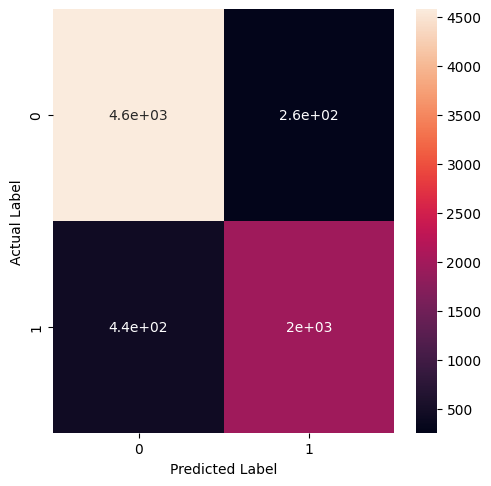

In [44]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(5.5,5.5))
sns.heatmap(confmat,annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

In [45]:
from sklearn.metrics import auc,accuracy_score


In [46]:
model_clf.fit(X_train,y_train)
ypred=model_clf.predict(X_valid)
accuracy_score(y_valid,ypred)
     

0.9031013094417643

So we have our final Model to help Hotels make predictions

the 3 most important features are lead_time,average price per room and no_of_special_requests.
The next stage is deployment. 